# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# I added this to reduce runtimewarning messages
import warnings
warnings.filterwarnings('ignore')

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

/Users/fjlind8/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/fjlind8/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home = '~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

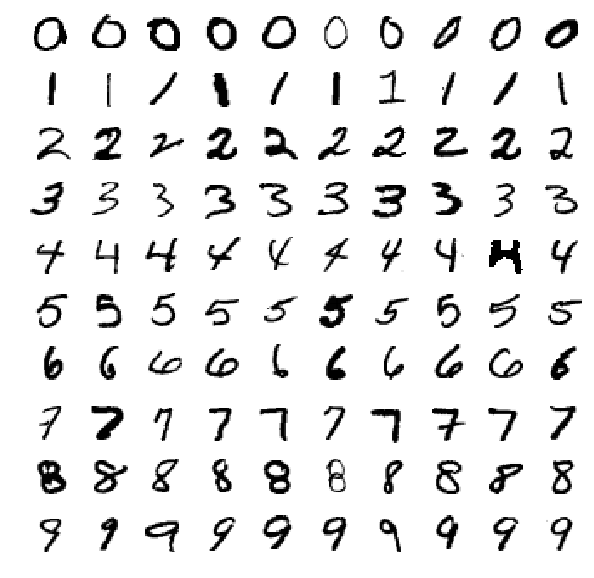

In [3]:
def P1(num_examples = 10):
    
### STUDENT START ###
    
    fig, ax = plt.subplots(10, num_examples, figsize = (10, 10))
    unique = list(set(mini_train_labels))

    for i in range(len(unique)):
        # Choose a random subset of each unique value in the label set Y
        indices = np.random.choice(np.where(mini_train_labels == unique[i])[0], num_examples).tolist()

        for j in range(len(indices)):
            ax[i, j].imshow(mini_train_data[indices[j]].reshape((28, 28)), cmap = 'binary')
            ax[i, j].axis('off')
            
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

### STUDENT START ###

    for i in k_values:
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(mini_train_data, mini_train_labels)
        
        print('k = {} ; accuracy = {:.4}'.format(i, knn.score(dev_data, dev_labels)))
        
        if i == 1:
            dev_preds = knn.predict(dev_data)
            
            print()
            print(classification_report(dev_labels, dev_preds, digits = 4))
            
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

k = 1 ; accuracy = 0.888

             precision    recall  f1-score   support

        0.0     0.9065    0.9798    0.9417        99
        1.0     0.8898    1.0000    0.9417       105
        2.0     0.9878    0.7941    0.8804       102
        3.0     0.7732    0.8721    0.8197        86
        4.0     0.8854    0.8173    0.8500       104
        5.0     0.9268    0.8352    0.8786        91
        6.0     0.9400    0.9592    0.9495        98
        7.0     0.8889    0.9204    0.9043       113
        8.0     0.9438    0.8750    0.9081        96
        9.0     0.7768    0.8208    0.7982       106

avg / total     0.8924    0.8880    0.8878      1000

k = 3 ; accuracy = 0.878
k = 5 ; accuracy = 0.869
k = 7 ; accuracy = 0.865
k = 9 ; accuracy = 0.863


ANSWER: The number 9 is the most difficult to interpret, as it has the lowest F1 score of 0.7982. It has the second lowest precision and the third lowest recall.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):

### STUDENT START ###

    for i in range(len(train_sizes)):
        time_start = time.time()
        train_i, labels_i = X[:train_sizes[i]], Y[:train_sizes[i]]
        knn = KNeighborsClassifier(n_neighbors = 1)
        knn.fit(train_i, labels_i)
        accuracies.append(knn.score(dev_data, dev_labels))
        
        print('Train size = {} ; Accuracy = {:.4} ; Run time (seconds) = {}'.format(train_sizes[i], accuracies[i], time.time() - time_start))

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Train size = 100 ; Accuracy = 0.72 ; Run time (seconds) = 0.12830400466918945
Train size = 200 ; Accuracy = 0.786 ; Run time (seconds) = 0.25408005714416504
Train size = 400 ; Accuracy = 0.841 ; Run time (seconds) = 0.4852762222290039
Train size = 800 ; Accuracy = 0.884 ; Run time (seconds) = 0.9784269332885742
Train size = 1600 ; Accuracy = 0.902 ; Run time (seconds) = 1.9809248447418213
Train size = 3200 ; Accuracy = 0.926 ; Run time (seconds) = 4.007016181945801
Train size = 6400 ; Accuracy = 0.937 ; Run time (seconds) = 8.026576042175293
Train size = 12800 ; Accuracy = 0.959 ; Run time (seconds) = 16.409544944763184
Train size = 25000 ; Accuracy = 0.97 ; Run time (seconds) = 33.453831911087036


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
def P4():

### STUDENT START ###
    
    regr_X = np.asarray(train_sizes).reshape(-1, 1)
    regr_Y = np.asarray(accuracies).reshape(-1, 1)
    dev_X = np.asarray([60000])
    lm = LinearRegression()

    # Train the model
    lm.fit(regr_X, regr_Y)

    # Make prediction
    pred_Y = lm.predict(dev_X)
    print('Regular model prediction = {}'.format(pred_Y))
    
    # Attempt a log transformation
    regr_X_log = np.log10(regr_X)
    dev_X_log = np.log10(dev_X)
    
    # Train the log model
    lm_log = LinearRegression()
    lm_log.fit(regr_X_log, regr_Y)
    
    # Make log prediction
    pred_Y_log = lm_log.predict(dev_X_log)
    print('Log model prediction = {}'.format(pred_Y_log))

### STUDENT END ###

P4()

Regular model prediction = [[ 1.24307226]]
Log model prediction = [[ 1.03386514]]


ANSWER: Regression is not an appropriate model here because the accuracy prediction for training size of 60000 is 1.243, and accuracy cannot be greater than 1. I attempted a log transformation (stronger than square or cube root) but the predicted value was still above 1.

(5) Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


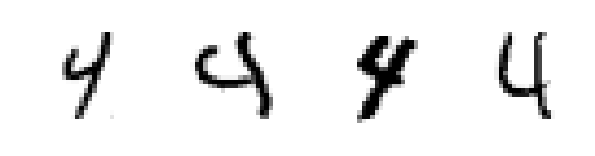

In [7]:
def P5():

### STUDENT START ###
    
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(mini_train_data, mini_train_labels)
    dev_preds = knn.predict(dev_data)
    
    print(confusion_matrix(dev_labels, dev_preds))
    
    # View 3 examples of the most common mistake
    fours_not_nines = []
    
    for i in range(len(dev_preds)):
        if dev_labels[i].astype(int) == 4 and dev_preds[i].astype(int) == 9:
            fours_not_nines.append(i)
    
    num_examples = 4
    fig, ax = plt.subplots(1, num_examples, figsize = (10, 5))

    for i in range(len(fours_not_nines)):
        # Choose a random subset of each unique value in the label set Y
        indices = np.random.choice(fours_not_nines, num_examples).tolist()
        
        for j in range(len(indices)):
            ax[j].imshow(dev_data[indices[j]].reshape((28, 28)), cmap = 'binary')
            ax[j].axis('off')
    
### STUDENT END ###

P5()

ANSWER: The confusion matrix shows the highest incorrect prediction where the actual value was 4 but the model predicted a 9 (14 cases). I displayed 3 examples of those cases.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

Accuracy for preprocessing training but not dev = 0.905
Accuracy for preprocessing dev but not training = 0.865
Accuracy for preprocessing both training and dev = 0.903


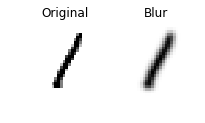

In [8]:
from scipy.ndimage import gaussian_filter

def P6():
    
### STUDENT START ###
    
    preproc_mini_train = np.zeros(shape = (len(mini_train_data), 784))
    preproc_dev = np.zeros(shape = (len(dev_data), 784))
    
    for i in range(len(preproc_mini_train)):
        preproc_mini_train[i] = gaussian_filter(mini_train_data[i].reshape((28, 28)), sigma = 1).reshape((1, 784))
    
    for j in range(len(preproc_dev)):
        preproc_dev[j] = gaussian_filter(dev_data[j].reshape((28, 28)), sigma = 1).reshape((1, 784))
        
    # Show an example of the blurring filter compared to the original
    num_examples = 2
    fig, ax = plt.subplots(1, num_examples, figsize = (3, 6))
    
    ax[0].imshow(mini_train_data[0].reshape((28, 28)), cmap = 'binary')
    ax[0].axis('off')
    ax[0].set_title('Original')
    
    ax[1].imshow(preproc_mini_train[0].reshape((28, 28)), cmap = 'binary')
    ax[1].axis('off')
    ax[1].set_title('Blur')
    
    # Test the accuracies of the three combinations using k = 1
    knn = KNeighborsClassifier(n_neighbors = 1)
    knn.fit(preproc_mini_train, mini_train_labels)    
    print('Accuracy for preprocessing training but not dev = {:.4}'.format(knn.score(dev_data, dev_labels)))
         
    knn2 = KNeighborsClassifier(n_neighbors = 1)
    knn2.fit(mini_train_data, mini_train_labels)  
    print('Accuracy for preprocessing dev but not training = {:.4}'.format(knn2.score(preproc_dev, dev_labels)))
          
    knn3 = KNeighborsClassifier(n_neighbors = 1)
    knn3.fit(preproc_mini_train, mini_train_labels) 
    print('Accuracy for preprocessing both training and dev = {:.4}'.format(knn3.score(preproc_dev, dev_labels)))
          
### STUDENT END ###

P6()

ANSWER: Both cases where we trained at least the train data yield higher accuracy than what was observed in P2, but I'm surprised that blurring only the training set yields better results than blurring train and dev. I only stuck with k = 1 for sake of processing time.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [9]:
def P7():

### STUDENT START ###

    bnb = BernoulliNB(binarize = 0.0)
    bnb.fit(mini_train_data, mini_train_labels)
    print('Bernoulli Naive Bayes Accuracy = {:.4}'.format(bnb.score(dev_data, dev_labels)))
          
    # I need to map pixel values to 0, 1, or 2 manually since I didn't see a way to do that in MultinomialNB()
    # I'll be using the np.digitize function
    bins = np.array([0.0, 0.5, 1.0])
    binned_mini_train_data = np.digitize(mini_train_data, bins) - 1
    binned_dev_data = np.digitize(dev_data, bins) - 1

    mnb = MultinomialNB()
    mnb.fit(binned_mini_train_data, mini_train_labels)
    print('Multinomial Naive Bayes Accuracy = {:.4}'.format(mnb.score(binned_dev_data, dev_labels)))
    
### STUDENT END ###

P7()

Bernoulli Naive Bayes Accuracy = 0.815
Multinomial Naive Bayes Accuracy = 0.797


ANSWER: The multi-class version does not improve the results, as we observe an accuracy of 0.797 compared to 0.815 for the Bernoulli Naive Bayes classifier. This could be that the [at least] three way mapping actually creates more noise in the input than the model can handle.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [10]:
def P8(alphas):

### STUDENT START ###

    bnb = BernoulliNB(binarize = 0.0)
    grid_search = GridSearchCV(bnb, alphas)
    grid_search.fit(mini_train_data, mini_train_labels)
    
    for i in grid_search.grid_scores_:
        print(i)
        
    print()
    print('The best parameters are {}'.format(grid_search.best_params_))
    
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
P8(alphas)

mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}
mean: 0.82000, std: 0.02208, params: {'alpha': 0.0001}
mean: 0.82000, std: 0.02305, params: {'alpha': 0.001}
mean: 0.82000, std: 0.02607, params: {'alpha': 0.01}
mean: 0.82100, std: 0.02454, params: {'alpha': 0.1}
mean: 0.81900, std: 0.02147, params: {'alpha': 0.5}
mean: 0.81200, std: 0.01814, params: {'alpha': 1.0}
mean: 0.81000, std: 0.01767, params: {'alpha': 2.0}
mean: 0.77500, std: 0.01719, params: {'alpha': 10.0}

The best parameters are {'alpha': 0.1}


ANSWER: The best value for alpha is 0.1 as the mean accuracy is 0.821, just slightly higher than when alpha is equal to 0.0001, 0.001, or 0.01. When alpha is 0.0, the model has a terrible score relative to the other values, likely because the training set is not smoothed at all.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [11]:
def P9():

### STUDENT END ###

    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print('Gaussian Naive Bayes accuracy = {:.4}'.format(gnb.score(dev_data, dev_labels)))
    
    # Try fixed sigma of 1 to control for the bimodal nature of the pixel values
    gnb.sigma_ = np.ones_like(gnb.sigma_)
    print('Gaussian Naive Bayes accuracy with sigma as 1 = {:.4}'.format(gnb.score(dev_data, dev_labels)))

### STUDENT END ###

P9()

Gaussian Naive Bayes accuracy = 0.621
Gaussian Naive Bayes accuracy with sigma as 1 = 0.802


ANSWER: By examining some example rows, notice the pixel values are somewhat bimodal, with large concentrations near 0.0 and 1.0, which affects the mean (theta) and variance (sigma) of each feature in the model. As sigma is in the denomenator of our P(X_i | Y) formula, attempt keeping sigma constant at 1. This improves the result quite a bit as the accuracy increases to 0.802. Different sigma values could be experimented with.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

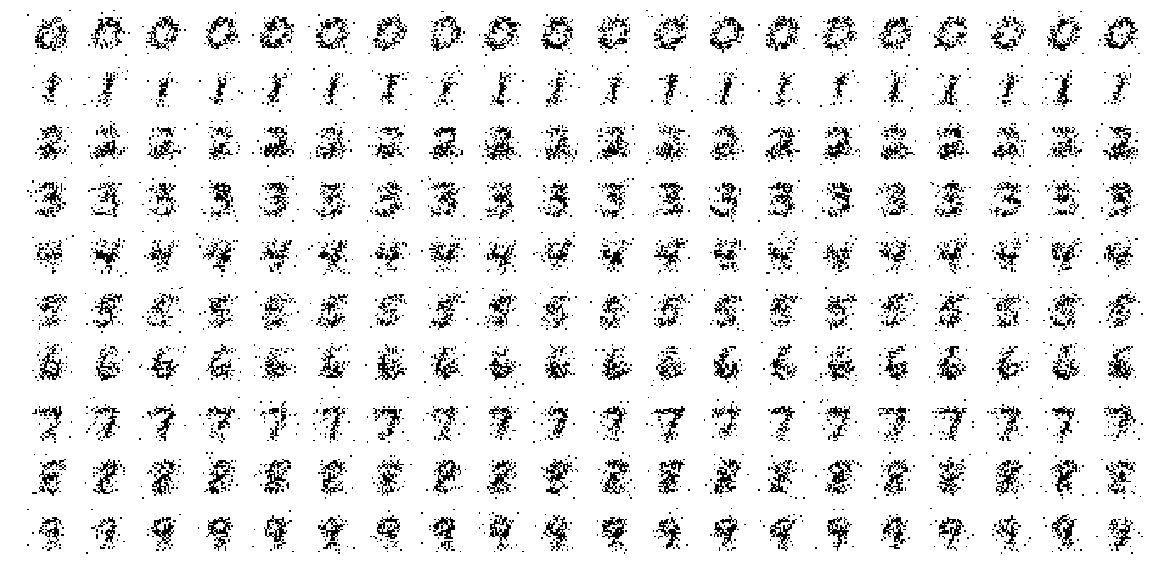

In [12]:
def P10(num_examples):

### STUDENT START ###
    
    bnb = BernoulliNB(binarize = 0.5)
    bnb.fit(mini_train_data, mini_train_labels)
    probabilities = np.exp(bnb.feature_log_prob_)
    
    fig, ax = plt.subplots(10, num_examples, figsize = (num_examples, 10))
    unique = list(set(mini_train_labels))

    for i in range(len(unique)):
        
        for j in range(num_examples):
            ax[i, j].imshow((np.random.rand(784) < np.exp(bnb.feature_log_prob_[i])).reshape(28,28), cmap = 'binary')
            ax[i, j].axis('off')

### STUDENT END ###

P10(20)

ANSWER: The generated digits look much worse than the training digits. Some generated digits are nearly indiscernible.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [13]:
def P11(buckets, correct, total):
    
### STUDENT START ###

    # We'll use the best alpha we saw from P8
    bnb = BernoulliNB(alpha = 0.1, binarize = 0.0)
    bnb.fit(mini_train_data, mini_train_labels)
    preds = bnb.predict(dev_data)
    probabilities = bnb.predict_proba(dev_data) 
    
    for i in range(len(dev_labels)):
        # Assess whether the prediction matched the label
        match = 0
        
        if preds[i] == dev_labels[i]:
            match = 1
        
        # Add to the correct and total list only when the max probability reaches the highest bucket in the defined list
        for j in range(len(buckets)):
            if np.amax(probabilities[i]) <= buckets[j]:
                correct[j] += match
                total[j] += 1
                break
    
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   2    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  31    accuracy = 0.387
p(pred) <= 0.9990000000000    total =  71    accuracy = 0.493
p(pred) <= 0.9999900000000    total =  53    accuracy = 0.434
p(pred) <= 0.9999999000000    total =  64    accuracy = 0.609
p(pred) <= 0.9999999990000    total =  46    accuracy = 0.543
p(pred) <= 0.9999999999900    total =  52    accuracy = 0.808
p(pred) <= 0.9999999999999    total =  49    accuracy = 0.796
p(pred) <= 1.0000000000000    total = 632    accuracy = 0.951


ANSWER: The accuracy generally improves as the posterior probability increases, but not in all cases. Notice the accuracy for posterior probability of 0.999 is greater than the accuracy for posterior probability of 0.99999. This pattern continues, as posterior probability increases, accuracy makes a large increase, followed by a small decrease, then another large increase, etc. This means the model is not well calibrated.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [ ]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()